In [1]:
#purpose is to determine extinctions, first collecting some files
'''
Paths and file needs:
*imglams and spitzer_conversions are excel files, right now I have it so you need to put it as same directory as your code (but could later maybe just give it a path to go to - would be smarter)
*paths to images and data in general
'''
#now the steps
'''
1) read in all the data by noting all the paths to the continuum subtracted hst images
2) loop through all the data, read it in, convert units
(optional) 3) cutout all the data as appropriate
3) determine extinctions using a line ratio with common upper states. 
4) de-extinct all the images and save the ratio image and extinction image. 
also determine poisson uncertainty map to be used for later analysis
'''

#just to check python version - should be 3.8.13
from platform import python_version
print(python_version())

#importing libraries
from astropy.io import fits
from astropy.wcs import WCS
import glob
import itertools
import matplotlib 
matplotlib.use('Agg') #invokved b/c just plain matplotlib was insufficient
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys

#this part is unnecessary...in jupyter...but if you're scripting and want to test blocks of code
#you may want switches, EX:
# switch1 = 'on' #convolving images [needed to put it on for switch 3 at min...need to figure out other solution, eh]
# switch1b = 'on' #regridding...
# switch2 = 'on' #solving equations
# switch3 = 'on' #plotting / graphics of solutions

3.8.13


In [2]:
#a new fits file to be saved and viewed in DS9
def fits_saver(array, wcs_header, name, save_path):
    '''
    array is a 2d array of data - could be from reprojecting one image onto another or from convolution
    wcs_header is a header containing the wcs coords of the image that we projected onto or of the orig image (if from the convolution)
    name is the path to some image you're using. It will get string split at the / character, and the func only takes the last element of that splitting
    save_path is the folder you want to save to...recommended to also add something to the start of the images names to make it clear what you did to them (e.g. 'Regridded/regrid_')
    '''
    
    #an option if you have trick spitzer data or weird cards in your header
    #creating a new file and adding the reprojected array of data as well as the WCS that we projected onto
#     if [badkey for badkey in wcs_header if badkey == 'ORGNAME'] == []:
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
#     else:
#         wcs_header = wcs_header.remove('ORGNAME')
#         hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    
    #otherwise, just setup an fits HDU from the data
    hdu_new = fits.PrimaryHDU(array, header=wcs_header)
    hdul = fits.HDUList([hdu_new])
    
    #saving the file
    if name.find('FIT') == -1: #needed if file end incorrect
        new_filename = name.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)     
    else:
        name_fixfit = name[:-3] + 'fits'
        new_filename = name_fixfit.split('/')[-1]  #grabs the file name we were using from before
        hdul.writeto(save_path+new_filename, overwrite=True)
        
    return (save_path+new_filename)

In [3]:
#paths to our data
path_list = 'nocont*'
file_list = [i.replace('\\', '/') for i in glob.glob(path_list)]
print(file_list)

#opening data and headers
hdu_list = [fits.open(i) for i in file_list]
hdu_data_list = []
noise = [1.55e-18] * len(file_list)
for i in range(len(hdu_list)): 
    hdu_data = hdu_list[i][0].data
    # hdu_data[hdu_data > 1e-14] = 0
    # hdu_data[hdu_data < 2 * noise[i]] = 0
    hdu_data_list.append(hdu_data)
hdu_header_list = [i[0].header for i in hdu_list]

print([i.shape for i in hdu_data_list]) #checking they're all consistently cutout and shaped

['nocont_126n_updated_pos.fits', 'nocont_128n_updated_pos.fits', 'nocont_164n_updated_pos.fits']
[(1982, 2229), (1982, 2229), (1982, 2229)]


In [4]:
from scipy.interpolate import CubicSpline

#need a wcs standard for regridding and plots, fits files...
w_list = [WCS(i) for i in hdu_header_list] #wcs_cutout_list[regrid_ind] # WCS(hdu_header_list[0]) #I picked 0 arbitrarily, it shouldn't really matter
# wcs_header = w.to_header()
# print(w)


#for de-extincting, you need the file below! It is taken from Bruce Draine's website for Rv = 5.5, to be interpolated
#this is used for the cross sections Cext or kext, which can be used to compute tau or Av
#extracting data
kext_dat = np.genfromtxt('kext_albedo_WD_MW_5.5A_30_D03_delimmod.txt', delimiter=' ', dtype=None, skip_header=80, usecols=range(0,5)) #reading in excel file of extinctions
kext_dat_ascend = sorted(kext_dat, key=lambda x:x[0]) #sorted in ascending order, from small to large lambda

#extracting relevant data and interpolating
lam_kext = [i[0] for i in kext_dat_ascend]
Cext_kext = [i[3] for i in kext_dat_ascend]
vs = CubicSpline(lam_kext, Cext_kext) #the all important interpolating function

#checking values
lambdaV = 0.547
lambdaB = 0.4405
print('Rv you should get is 5.5, you get: ', vs(lambdaV) / (vs(lambdaB) - vs(lambdaV))) #checks Rv value


#next part, applying formula we require, which is optical depth as function of lambda, iron 2 ratio
lam_chosen = 0.656 #lambda should be in microns, this is used for making a test image, e.g. lam=HAlpha here
C_ext_Fe2const = vs(1.2570) - vs(1.6440) #constant used in formula

#computing 1.26 to 1.64 ratio from our images...originally based on up to 95 to 99% of the EDF or histogram of line ratios
s0 = 2.6 #1.8 or 2 according to tyal and zatsarinny 2018 #
s = hdu_data_list[0] / hdu_data_list[2] #the chosen ratio, 1.26 / 1.64
#options if you want filters
# s[s>s0]=np.nan #above our chosen ratio, we ignore because would result in negative extinction ?
# s[s<=0.01]=np.nan #AMANDA UPDATE: adjusting range

tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula for tau
print('For example, HAlpha: ', tau_ext)

#now we need wavelengths to use our interpolating function...it is a func of wavelength after all...
#unfortunately, our images sometimes are not ordered by wavelength or neatly named so...need something to match/extract it
#I opt to use a wavelength spreadsheet and then just match strings or header cards
df = pd.read_excel('imglams.xlsx') #the wavelength possibilities, must change
cols = df.columns
cols_str = [str(i) for i in df[cols[0]]]

lam_list = []
for name in file_list:
    #this finds the loc in the excel file where the image substring matches our image name
    #it then finds the wavelength value corresponding to that loc
    lam =  df.loc[np.where([i in name for i in cols_str])[0][0]].values[1] #lambda in microns
    lam_list.append(lam)

    
#computing tau for each image, then taking image * exp(tau) to de-extinct, and saving
res_str='flam' #can change, for file naming
file_start = 'deext_'+res_str+'_' #can change, for file naming
hdu_deextincted_list = []
for n in range(len(hdu_data_list)):
    tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.log(s0 / s) #applying tau formula at each image's wavelength
    hdu_deextinc = hdu_data_list[n] * np.exp(tau_ext)
#     implot(hdu_deextinc, w_list[n], False, np.max(hdu_deextinc))  
    deext_path = fits_saver(hdu_deextinc, hdu_header_list[n], file_list[n], file_start)
    hdu_deextincted_list.append(hdu_deextinc)

#some reference values you can use to check yourself
print('lambdaV: ', lambdaV, 'lambdaB: ', lambdaB)
print('Rv: ', vs(lambdaV) / (vs(lambdaB) - vs(lambdaV)))
print('Cv(lamV): ', vs(0.547))
print('C(lam126) - C(lam164): ', C_ext_Fe2const)
print('C(lam) / [C(126) - C(164)]: ', vs(lam_list[n]) / C_ext_Fe2const)
print('log(s0/s): ', np.log(s0/s))

#some reference files that are useful (e.g. tau, Av, the ratio image, etc)
# R_Fe = vs(0.547) / C_ext_Fe2const
R_V = vs(0.547) / C_ext_Fe2const
print(R_V)
tau_ext = vs(0.547) / C_ext_Fe2const * np.log(s0 / s)
taupath = fits_saver(tau_ext, hdu_header_list[0], 'tau_'+str(0.547)+'.fits', file_start)
# avpath = fits_saver(2.5 * np.log10(np.exp(1.)) * tau_ext, wcs_cutout_list[regrid_ind], 'Deextintcted/Av_'+str(0.547)+'.fits', file_start)
avpath = fits_saver(2.5 * R_V * np.log10(s0 / s), hdu_header_list[0], 'Av_'+str(0.547)+'.fits', file_start)

ratiopath = fits_saver(s, hdu_header_list[0], '126_164_for_dext.fits', file_start)
ratiopath = fits_saver(s0/s, hdu_header_list[0], 's0_s_ratio_'+str(lam_list[n])+'.fits', file_start)
ratiopath = fits_saver(np.log(s0/s), hdu_header_list[0], 'ln_s0_s_ratio_'+str(lam_list[n])+'.fits', file_start)
taupath = fits_saver(tau_ext, hdu_header_list[0], 'tau_'+str(lam_list[n])+'.fits', file_start)
taupath = fits_saver(np.exp(tau_ext), hdu_header_list[0], 'exp_tau_'+str(lam_list[n])+'.fits', file_start)

Rv you should get is 5.5, you get:  5.545004128819156
For example, HAlpha:  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]


C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:32: RuntimeWarning: divide by zero encountered in true_divide
  s = hdu_data_list[0] / hdu_data_list[2] #the chosen ratio, 1.26 / 1.64
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:37: RuntimeWarning: divide by zero encountered in log
  tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula for tau
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:37: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(lam_chosen) / C_ext_Fe2const * np.log(s0 / s) #applying formula for tau
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:60: RuntimeWarning: divide by zero encountered in log
  tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.log(s0 / s) #applying tau formula at each image's wavelength
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:60: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(lam_list[n]) / C_ext_Fe2const * np.l

lambdaV:  0.547 lambdaB:  0.4405
Rv:  5.545004128819156
Cv(lamV):  6.715e-22
C(lam126) - C(lam164):  7.000751815080524e-23
C(lam) / [C(126) - C(164)]:  1.7006106517988349
log(s0/s):  [[nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 ...
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]
 [nan nan nan ... nan nan nan]]
9.591826959977388


C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:72: RuntimeWarning: divide by zero encountered in log
  print('log(s0/s): ', np.log(s0/s))
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:72: RuntimeWarning: invalid value encountered in log
  print('log(s0/s): ', np.log(s0/s))
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:78: RuntimeWarning: divide by zero encountered in log
  tau_ext = vs(0.547) / C_ext_Fe2const * np.log(s0 / s)
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:78: RuntimeWarning: invalid value encountered in log
  tau_ext = vs(0.547) / C_ext_Fe2const * np.log(s0 / s)
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:81: RuntimeWarning: divide by zero encountered in log10
  avpath = fits_saver(2.5 * R_V * np.log10(s0 / s), hdu_header_list[0], 'Av_'+str(0.547)+'.fits', file_start)
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\888316572.py:81: RuntimeWarning: invalid value encountered in log10
 

In [5]:
#distances to help with fit
knot_source_dist = [0.01822046, 0.04205783, 0.06185785, 0.08663537, 0.08924019, \
                       0.09395867, 0.11148708, 0.11723194, 0.13494519, 0.17807351, 0.18420528]

#Av data, taken from measurements_by_hand when putting together tables
Av_list = np.array([30.2658, 24.0487, 9.60311, 15.9761, 17.1154, 20.325, 30.7061, 31.4283, 20.7581, 7.70811, 1.91259])
#median values work better...otherwise need some sorta cutoff...?
Av_uncert_list = np.array([1.62917, 1.48497, 3.84992, 0.731258, 0.672574, 0.967529, 1.80339, 1.12745, 2.03989, 8.7811, 8.74607])

#using the Av values from C18O emission measured by Iwata et al 1988
# Av_C18O = ((0.84+0.28*6) + 0.4) / (0.21)
Av_C18O = 14.55
Av_cloudback = Av_C18O + np.max(Av_list)

# #testing extrema in cases where the C18O value can vary in worst case scenario...
# print(np.max(Av_list) + ((0.84+0.28*6) + 0.4 - 0.1) / (0.21 + 0.01))
# print(np.max(Av_list) + ((0.84+0.28*6) + 0.4 + 0.1) / (0.21 - 0.01))
# print(Av_cloudback - (np.max(Av_list) + ((0.84+0.28*6) + 0.4 - 0.1) / (0.21 + 0.01)))
# print(Av_cloudback - (np.max(Av_list) + ((0.84+0.28*6) + 0.4 + 0.1) / (0.21 - 0.01)))
# #this implies the denominator can be +1.09 or -1.20...so mean uncertainty of about 1.15
# #this also means we must add 1.15 to all the Av_uncert_list values
# Av_uncert_list += 1.15
Av_uncert_list += 1.6 #found from the C18O value on average

#to check
print(Av_list)
print(Av_uncert_list)
print(Av_C18O)
print(Av_list / Av_cloudback)

[30.2658  24.0487   9.60311 15.9761  17.1154  20.325   30.7061  31.4283
 20.7581   7.70811  1.91259]
[ 3.22917   3.08497   5.44992   2.331258  2.272574  2.567529  3.40339
  2.72745   3.63989  10.3811   10.34607 ]
14.55
[0.6582627  0.52304457 0.20886179 0.34747044 0.37224952 0.44205636
 0.66783896 0.68354637 0.45147602 0.16764669 0.04159767]


In [17]:
#options are cutout2D from astropy or photutils apertures (my preference)
# https://docs.astropy.org/en/stable/nddata/utils.html#cutout-images
from astropy import units as u
from astropy.wcs.utils import skycoord_to_pixel
from astropy.coordinates import SkyCoord, FK5, ICRS
from photutils.aperture import EllipticalAperture

#known pixel size
hst_pixsize = 0.12825 #arcsec

#reading in the .reg files made using DS9 
f1 = open('../measurements_by_hand/epoch2_361c_byhand_ellipses_ordered.reg', 'r')
file1_output = []
file2_output = []

#looping through files
for line in f1:
    file1_output.append(line)
f1.close()

#fix file contents
#contents are ra, dec, width, height, rotation
file1_output = [i[8:-2] for i in file1_output[3:]]

#next step is for image, loop through all regions and make a list of region properties
sq_ra_diff_list = []
sq_dec_diff_list = []
sq_ra_pix_list = []
sq_dec_pix_list = []
side_a_list = []
side_b_list = []
sq_rotation_list = []

#coordinate details very much compacted (likely better ways to do this)
split_params1 = [i.split(',') for i in file1_output]
ra_hms_list = [(ra1[0].split(':')[0]+'h' + ra1[0].split(':')[1]+'m' + ra1[0].split(':')[2]+'s') for ra1 in split_params1]
dec_dms_list = [(dec1[1].split(':')[0]+'d' + dec1[1].split(':')[1]+'m' + dec1[1].split(':')[2]+'s') for dec1 in split_params1]

#offsets that can be used for finding knot offsets between epochs
pos_list = [SkyCoord(ra+' '+dec, frame=FK5, unit=(u.hourangle, u.deg)) for ra, dec in zip(ra_hms_list, dec_dms_list)] #this is all in degrees, what a lie...units are input units

#this isn't working for some reason...skycoord_to_pixel doesn't seem to like the units? not sure
ra_pix_list = [skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[0] for i in pos_list]
dec_pix_list = [skycoord_to_pixel(i, wcs=WCS(hdu_header_list[0]))[1] for i in pos_list]

#aperture size details in pixels (?)
rad_a_list = [1./hst_pixsize * float(a1[2][:-1]) for a1 in split_params1]
rad_b_list = [1./hst_pixsize * float(b1[3][:-1]) for b1 in split_params1]
rotation_list = [float(rot1[4]) for rot1 in split_params1]

# #making apertures
aperture_list = []
aper_mask_list = []
for i in range(len(ra_pix_list)):
    aperture_list.append(EllipticalAperture([ra_pix_list[i], dec_pix_list[i]], 
                                       rad_a_list[i], rad_b_list[i], theta=rotation_list[i]))
    aper_mask_list.append(aperture_list[i].to_mask())

C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\2624590414.py:33: RuntimeWarning: divide by zero encountered in log10
  data_interval = interval.get_limits(2.5 * R_V * np.log10(s0 / s))
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\2624590414.py:33: RuntimeWarning: invalid value encountered in log10
  data_interval = interval.get_limits(2.5 * R_V * np.log10(s0 / s))
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\2624590414.py:35: RuntimeWarning: divide by zero encountered in log10
  Av_map = 2.5 * R_V * np.nan_to_num(np.log10(s0 / s))
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\2624590414.py:35: RuntimeWarning: invalid value encountered in log10
  Av_map = 2.5 * R_V * np.nan_to_num(np.log10(s0 / s))
C:\Users\arubi\AppData\Local\Temp\ipykernel_10716\2624590414.py:35: RuntimeWarning: overflow encountered in multiply
  Av_map = 2.5 * R_V * np.nan_to_num(np.log10(s0 / s))


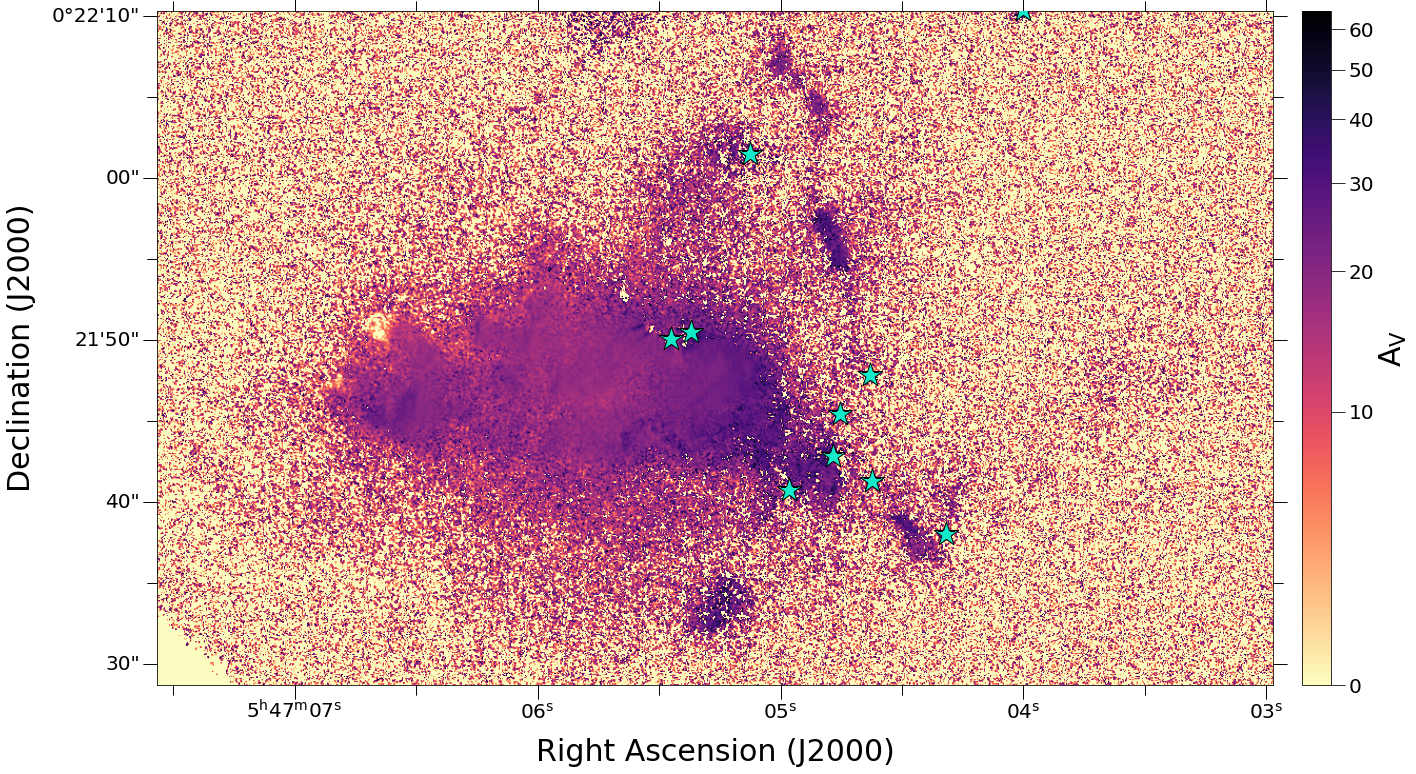

In [6]:
#plotting resulting image of extinction
from astropy.coordinates import SkyCoord
from astropy import units as u
from astropy.utils.data import get_pkg_data_filename
from astropy.visualization import ZScaleInterval, ImageNormalize
from astropy.visualization.stretch import AsinhStretch, HistEqStretch
from astropy.wcs.utils import skycoord_to_pixel
import matplotlib.ticker
                
#formatting for tick sizes
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#coordinates to IRS or HOPS objects, from Cheng et al 2022 or Tobin et al 2020 with GAIA
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s',\
            '5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s', '5h47m5.819s', '05h47m4.004s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', \
            '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s', '+00d22m37.45s', '+00d22m10.38s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[0])))

#figure setup
fig, ax = plt.subplots(figsize=(20, 20))
wcs = WCS(hdu_header_list[0])
ax = plt.subplot(projection=wcs)

#plotting
interval = ZScaleInterval()
data_interval = interval.get_limits(2.5 * R_V * np.log10(s0 / s))
norm = ImageNormalize(stretch=AsinhStretch(), vmin=0, vmax=65) #determine from ds9
Av_map = 2.5 * R_V * np.nan_to_num(np.log10(s0 / s))
Av_map[Av_map == np.inf] = 0
Av_map[Av_map == -np.inf] = 0
Av_map[Av_map == np.nan] = 0
Av_map[Av_map == -np.nan] = 0
# Av_map[Av_map < 0.1] = 0
# Av_map[Av_uncert > 10] = 0
im = ax.imshow(Av_map, norm=norm, origin='lower', cmap='magma_r') #note nans are zeroed
hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='xkcd:aqua', marker='*', \
                           edgecolor='black', s=650, zorder=5) for c_pair in coord_pix_list] #to plot hops sources


#plot a contour for signal to noise: THIS DOESN'T WORK
# X, Y = np.meshgrid(Av_map[700:1500, 1050:1850].shape[0], Av_map[700:1500, 1050:1850].shape[1])
# ax.contour(Av_map, [30], colors=['white'], vmin=0, vmax=40) #[1050:1850, 700:1500]

#instead plotting ellipses
# from matplotlib.patches import Ellipse
# for i in range(len(ra_pix_list)):
#     ellipse = Ellipse((ra_pix_list[i], dec_pix_list[i]), rad_a_list[i], rad_b_list[i], rotation_list[i], \
#                      color='aquamarine', fc='None', lw=1.5)
#     ax.add_patch(ellipse)

#general formatting
ax.set_xlim(470, 1530) # ax.set_xlim(700, 1500) 
ax.set_ylim(350, 990) # ax.set_ylim(1050, 1850) 
# ax.coords.grid(True, color='white', ls='solid', linewidth=0.75)
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True) #for minor ticks
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
# ax.invert_yaxis() #done because it's nicer with declination increasing going up
# ax.invert_xaxis() #and RA increasing left

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
# cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0-0.0635,0.02,ax.get_position().height+0.1265])
cax = fig.add_axes([ax.get_position().x1+0.02,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm A_V$', size=30)
cbar.ax.tick_params(labelsize=20)

#adding a compass
# theta_wcs = (135+180+27)*np.pi/180 #note that theta_wcs + the pi/n rotations below are only approx perpendicular...tricky
# x, y, arrow_length = 0.87, 0.71, 0.1 #this is the one thing you should have to change to get it in the right spot
# compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1/1.5*np.sin(theta_wcs+np.pi/3.), \
#             y+arrow_length*2/2*np.cos(theta_wcs+np.pi/3.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#             ha='center', va='center', fontsize=25, rotation=46,
#             xycoords='subfigure fraction') #ax.transAxes)
# compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*8/8*np.cos(theta_wcs+np.pi/2.), \
#             y-arrow_length*7/12*np.sin(theta_wcs+np.pi/2.)), 
#             arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
#             ha='center', va='center', fontsize=25, rotation=46,
#             xycoords='subfigure fraction') #ax.transAxes)

#observed Av ratio axis on side...converted to fractional depth using the previous cell
# ax2 = fig.add_axes([ax.get_position().x0,ax.get_position().y0+0.475,ax.get_position().width,ax.get_position().height])
# ax2.errorbar(knot_source_dist, Av_list/Av_cloudback, yerr=Av_uncert_list/Av_cloudback, \
#                marker='o', linestyle='', color='black') #observation
# ax2.set_xlabel('Knot-Protostar Separation (pc)', fontsize=30)
# ax2.set_ylabel('Fractional Depth into Cloud', fontsize=30)
# ax2.tick_params(axis='x', labelsize=20)
# ax2.tick_params(axis='y', labelsize=20)
# ax2.set_ylim(-0.2, 0.8)
# # ax2.set_xlim(0, 0.2)
# ax2.invert_xaxis() #and RA increasing left, needs to be done last

plt.savefig('Av_image.png', dpi=400, bbox_inches='tight')
plt.savefig('Av_image.pdf', dpi=400, bbox_inches='tight')

['../continuum_subtract/hdu0_hdu0_flam_err126n_thresh100_cw3.5_combined_drz.fits', '../continuum_subtract/hdu0_hdu0_flam_err128n_thresh100_cw3.5_combined_drz.fits', '../continuum_subtract/hdu0_hdu0_flam_err130n_thresh100_cw3.5_combined_drz.fits', '../continuum_subtract/hdu0_hdu0_flam_err164n_thresh100_cw3.5_combined_drz.fits', '../continuum_subtract/hdu0_hdu0_flam_err167n_thresh100_cw3.5_combined_drz.fits']
[(1096, 3035), (1096, 3035), (1096, 3035)]


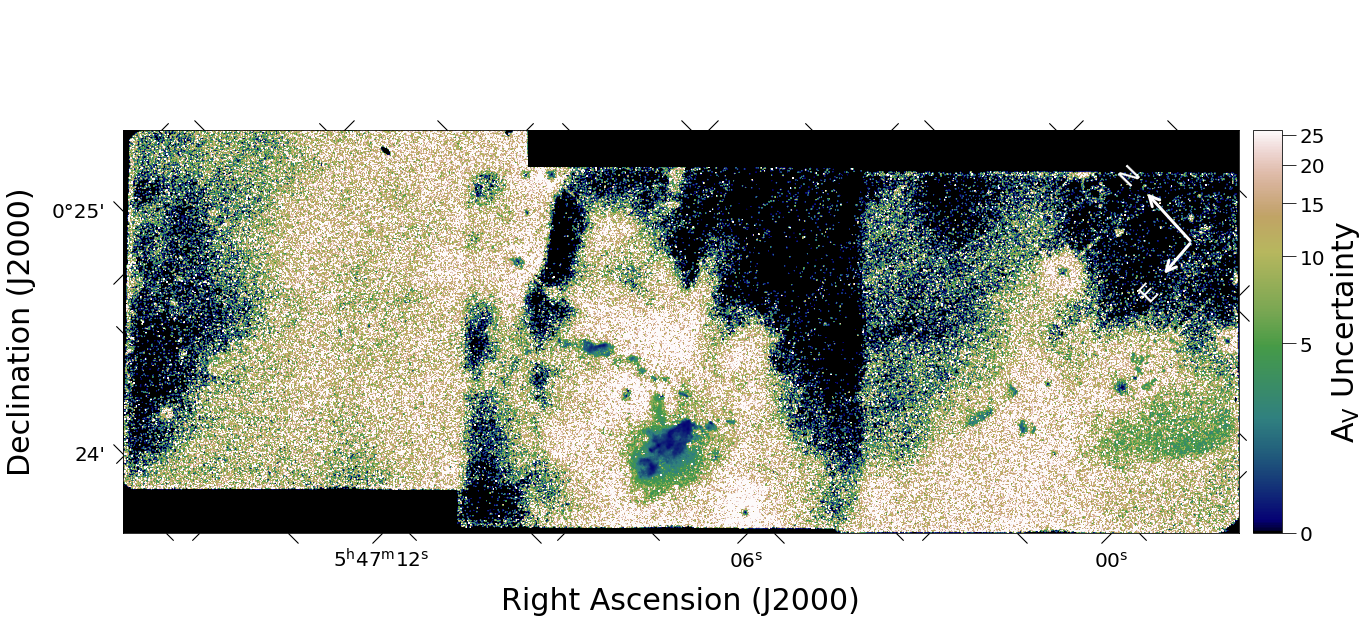

In [8]:
#finding uncertainty in Av...the map is more for personal use than general use
from astropy.visualization.stretch import SinhStretch

'''
propagation...formula works as 
2.5 * R_V * np.log10(s0 / s) means it's of form
const1 * log10 ( const2 / s )

applying expansion to log(x+deltax) = log(x) + deltax / x / ln(10) for small x
This means deltax/x is the first order uncertainty we care about
Multiplied by the const1, 2.5 * R_V

Now we must determine deltax, which comes from
s0/s ... the s0 is irrelevant if we consider it to be systematic error (handled separately)
Therefore, 1/s = delta_164/delta_126
Applying propagation formula s = A / B, then sig_s = s * sqrt((sigA/A)^2 + (sigB/B)^2)

Putting this together, we get...
2.5 * R_V * deltas / s / ln(10) = 2.5 * R_V * s * sqrt((sigA/A)^2 + (sigB/B)^2) / s / ln(10)
Meaning 2.5 * R_V * sqrt((sig_126/f_126)^2 + (sig_164/f_164)^2) / ln(10)

But line_filter = line - cont in general, meaning
delta_filter with form A-B then becomes ... sig_f = sqrt(sig_A^2 + sig_B^2 - 2*sig_AB)
sig_126 = sqrt(sig_orig126^2 + sig_130^2 - 2*sig_orig126_130)
sig_164 = sqrt(sig_orig164^2 + sig_167^2 - 2*sig_orig164_167)
For now, I assume to ignore the covariance, but it may be relevant
'''
#opening data and headers
path_list = '../continuum_subtract/hdu0*err*drz.fits'
file_list = [i.replace('\\', '/') for i in glob.glob(path_list)]
print(file_list)
hdu_list = [fits.open(i) for i in file_list]
hdu_err_list = [i[0].data for i in hdu_list]
hdu_header_list = [i[0].header for i in hdu_list]
print([i.shape for i in hdu_data_list])

#you'll have to change the indices below to match whichever image you want
sig_126 = np.sqrt((hdu_err_list[0])**2 + (hdu_err_list[2])**2)
sig_164 = np.sqrt((hdu_err_list[3])**2 + (hdu_err_list[4])**2)
Av_uncert = 2.5 * R_V * np.sqrt((sig_126/hdu_data_list[0])**2 + (sig_164/hdu_data_list[2])**2) / np.log(10.)
avpath = fits_saver(Av_uncert, hdu_header_list[0], 'Av_'+str(0.547)+'_uncert.fits', file_start)

#plotting resulting image as before
# plt.rcParams['xtick.labeltop'] = plt.rcParams['xtick.labelright'] = False
plt.rcParams['xtick.major.size'] = 14
plt.rcParams['ytick.major.size'] = 14

#coordinates for IRS or HOPS objects
ra_list  = ['5h47m4.785s','5h47m4.755s','5h47m4.631s','5h47m4.317s','5h47m4.623s','5h47m4.967s','5h47m5.367s','5h47m5.451s','5h47m5.125s']
dec_list = ['0d21m42.85s', '0d21m45.45s', '0d21m47.82s', '0d21m38.03s', '0d21m41.30s', '0d21m40.74s', '0d21m50.51s', '0d21m50.08s', '0d22m1.46s']
coord_sky_list = [SkyCoord(ra=i, dec=j, frame='icrs') for i,j in zip(ra_list, dec_list)]

coord_pix_list = []
for c in coord_sky_list:
    coord_pix_list.append(skycoord_to_pixel(c, WCS(hdu_header_list[0])))

#opening a figure
fig, ax = plt.subplots(figsize=(20, 20))
wcs = WCS(hdu_header_list[0])
ax = plt.subplot(projection=wcs)

#plotting
Av_uncert = np.nan_to_num(Av_uncert) #note we 0 any nans
interval = ZScaleInterval()
data_interval = interval.get_limits(Av_uncert)
# norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=data_interval[1])
norm = ImageNormalize(stretch=AsinhStretch(), vmin=data_interval[0], vmax=26) #determine from ds9
im = ax.imshow(Av_uncert, norm=norm, origin='lower', cmap='gist_earth')
# hops_sources = [ax.scatter(c_pair[0], c_pair[1], color='green', marker='+') for c_pair in coord_pix_list] #to plot hops sources

#colorbar, see 3rd answer from https://stackoverflow.com/questions/18195758/set-matplotlib-colorbar-size-to-match-graph
cax = fig.add_axes([ax.get_position().x1+0.01,ax.get_position().y0,0.02,ax.get_position().height])
cbar = plt.colorbar(im, cax=cax) 
cbar.ax.yaxis.get_offset_text().set_fontsize(0)
cbar.set_label(label=r'$\rm A_V~Uncertainty$', size=30)
cbar.ax.tick_params(labelsize=20)

#general formatting
# ax.coords.grid(True, color='white', ls='solid', linewidth=0.75)
ax.coords[0].set_axislabel('Right Ascension (J2000)', fontsize=30)
ax.coords[1].set_axislabel('Declination (J2000)', fontsize=30)   
ax.coords[0].set_minor_frequency(2) #for minor ticks
ax.coords[1].set_minor_frequency(2)
ax.coords[0].display_minor_ticks(True)
ax.coords[1].display_minor_ticks(True)
ax.tick_params(axis='x', labelbottom=True, labeltop=False, labelright=False) 
ax.tick_params(axis='x', labelsize=20)
ax.tick_params(axis='y', labelsize=20)
ax.tick_params(axis='x', which='minor', length=10)
ax.tick_params(axis='y', which='minor', length=10)
ax.invert_yaxis() #done because it's nicer with declination increasing going up
ax.invert_xaxis()

#compass arrow like the last plot
theta_wcs = (135+180+27)*np.pi/180
x, y, arrow_length = 0.87, 0.61, 0.1
compass_N = ax.annotate('N', xy=(x, y), xytext=(x-arrow_length*1/1.5*np.sin(theta_wcs+np.pi/3.), \
            y+arrow_length*2.9/2*np.cos(theta_wcs+np.pi/3.)), 
            arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
            ha='center', va='center', fontsize=25, rotation=46,
            xycoords='subfigure fraction') #ax.transAxes)
compass_E = ax.annotate('E', xy=(x, y), xytext=(x-arrow_length*8/8*np.cos(theta_wcs+np.pi/2.), \
            y-arrow_length*10/12*np.sin(theta_wcs+np.pi/2.)), 
            arrowprops=dict(arrowstyle='<-', lw=3, color='white'), color='white',
            ha='center', va='center', fontsize=25, rotation=46,
            xycoords='subfigure fraction') #ax.transAxes)

plt.savefig('Av_uncert_image.png', dpi=400, bbox_inches='tight')
plt.savefig('Av_uncert_image.pdf', dpi=400, bbox_inches='tight')